### Importando a biblioteca pandas e o dataset para o projeto


O dataset foi retirado do site kaggle.

In [1]:
import pandas as pd


dados = pd.read_csv('predictive_maintenance.csv')
dados.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


Agrupei o dataset em Tipos de Falhas e a quantidade de cada falha, gostaria de saber se estava equilibrado entre as falhas e não falhas... É interessante que a quantidade entre as duas variáveis esteja equilibrada para que tenhamos um bom treinamento do modelo.

In [2]:
dados.groupby('Failure Type').count()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
Failure Type,,,,,,,,,
Heat Dissipation Failure,112,112,112,112,112,112,112,112,112
No Failure,9652,9652,9652,9652,9652,9652,9652,9652,9652
Overstrain Failure,78,78,78,78,78,78,78,78,78
Power Failure,95,95,95,95,95,95,95,95,95
Random Failures,18,18,18,18,18,18,18,18,18
Tool Wear Failure,45,45,45,45,45,45,45,45,45


Como a diferença entre "Falhas" e "Não Falhas" é grande, decidi testar o modelo com apenas 2 tipos de dados dependentes: 0 e 1, o famoso dado booleano.

OBS: O "Target" = Alvo já possui esse tipo de dado, mas eu descobri alguns erros e vão ser mostrado mais adiante.

In [5]:
falha = {'Heat Dissipation Failure' : 1, 'No Failure' : 0, 'Overstrain Failure' : 1,
         'Power Failure' : 1, 'Random Failures' : 1, 'Tool Wear Failure' : 1}

In [6]:
dados['falha'] = dados['Failure Type'].map(falha)
dados = dados.drop(['Failure Type', 'Product ID', 'UDI', 'Type']	, axis=1)

Bom, aqui nós uma diferença de 9 elementos entre a falha (criada por mim) e o Target (original do DataFrame), eu vou optar pelos meus dados, pois eu troquei elementos por números de uma forma segura.   

In [11]:
dados.falha.value_counts()

0    9652
1     348
Name: falha, dtype: int64

In [10]:
dados.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [14]:
dados.Target.value_counts() - dados.falha.value_counts() 

0    9
1   -9
dtype: int64

Ampliando minha relação com o dataset, quero saber se existe algum valor vazio (count), a média da temperatura do ar em Grau Celsius é de 26.85° e a do processo é de 36.85° (observaremos no ".corr" que existe uma boa correlação entre as duas variáveis), quero analisar também os valores máximos e minimos a fim de ver se existem outliers.

In [ ]:
dados.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,falha
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.034800
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.183282
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000


Aqui vemos uma correlação entre: a Temperatura do Ar e do Processo, também entre Torque e Velocidade Rotacional, respectivamente, um caso indica correlação positiva e o outro negativa. 
Isso nos mostra que quanto mais quente o ar, maior a temperatura no processo da maquina e isso é uma coisa a ser notada pelas empresas que possuem essas máquinas. Nós também vemos uma correlação negativa entre o torque e a velocidade da rotação, o torque é a força de giro que gera em um motor para produzir velocidade, daí vem a sigla N.m (Newton x metro, ou força x raio), quando o motor já está em uma velocidade alta ele não precisa do aumento no torque, e ai que acontece a correlação negativa 

In [ ]:
dados.corr()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,falha
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.084453
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.039816
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,-0.045483
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,0.191563
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.105251
Target,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.959389
falha,0.084453,0.039816,-0.045483,0.191563,0.105251,0.959389,1.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Plotei os histogramas para entender como se trata a distribuição dos dados, alguns dados com uma tendência para a esquerda, indicando possíveis outliers (rotation speed), porem eu não vou tirá-los pois eu vi que esses outiliers são falhas e eu não posso tirá-los pois são dados importantes para minha generalização. Enfim, os restantes dos histogramas apontam uma boa distribuição (normal).

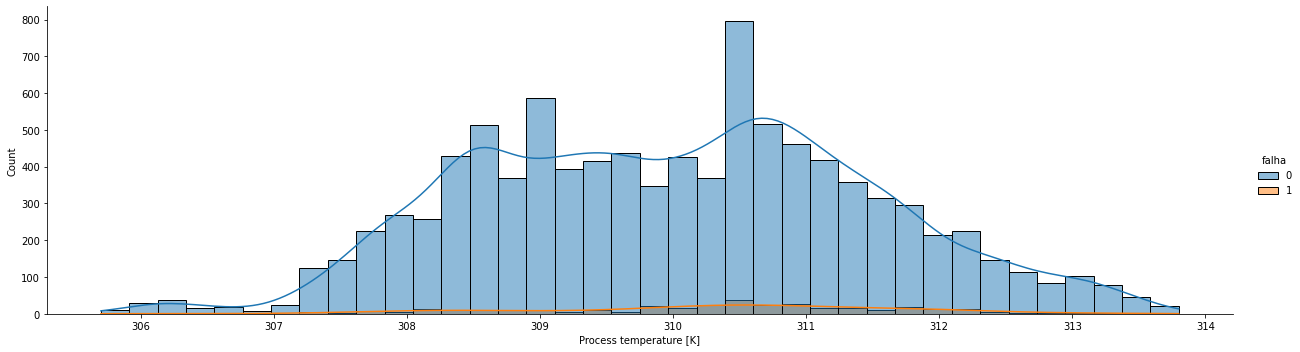

In [ ]:
ax = sns.displot(data=dados, x='Process temperature [K]', hue='falha', kde='Hist',height = 5, aspect = 3.5)

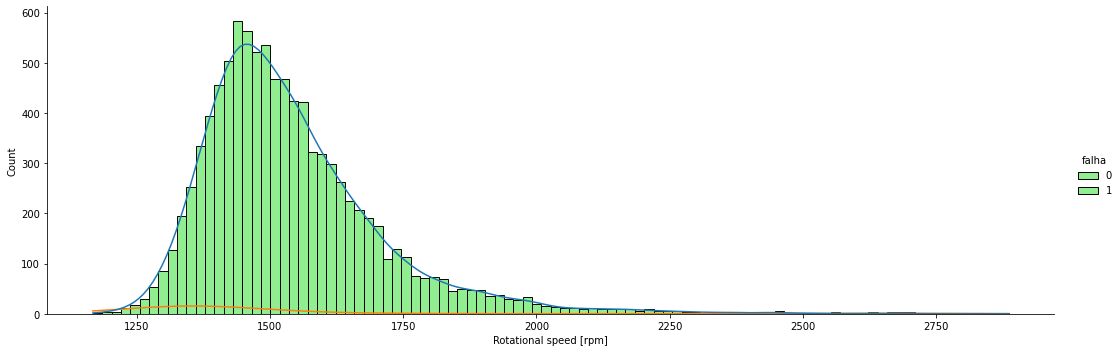

In [ ]:
ax = sns.displot(data=dados, x='Rotational speed [rpm]', hue='falha', kde='Hist', color = "blue", facecolor = "lightgreen",height = 5, aspect = 3)

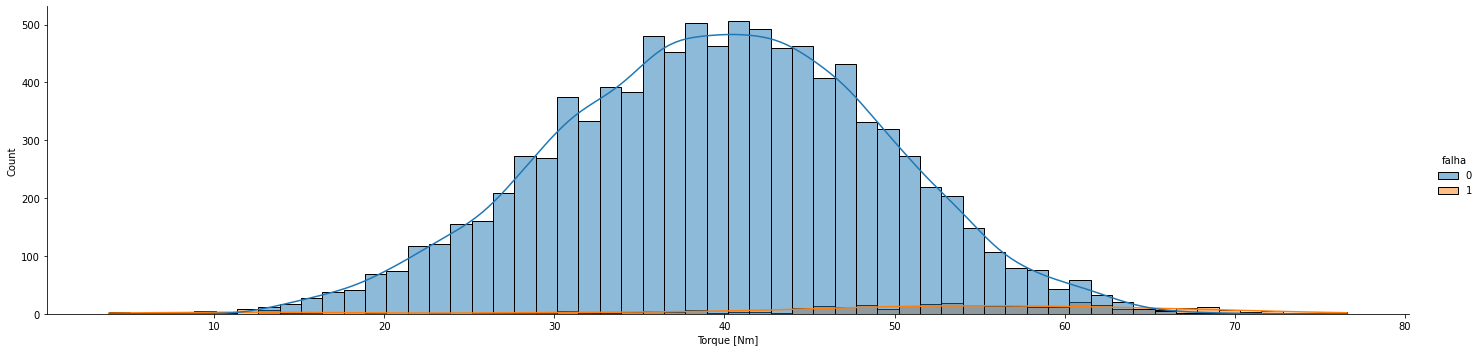

In [ ]:
ax = sns.displot(data=dados, x='Torque [Nm]', hue='falha', kde='Hist', height= 5, aspect=4)

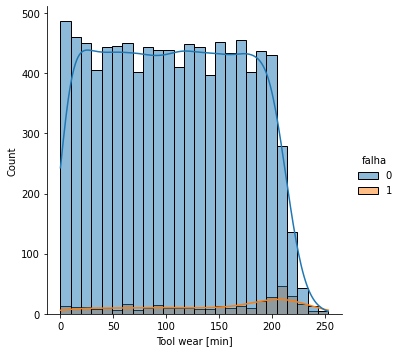

In [ ]:
ax = sns.displot(data=dados, x='Tool wear [min]', hue='falha', kde='Hist')

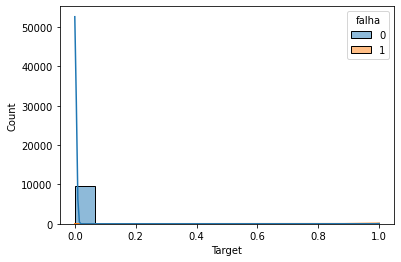

In [ ]:
ax = sns.histplot(data=dados, x='Target', hue='falha', kde='Hist')

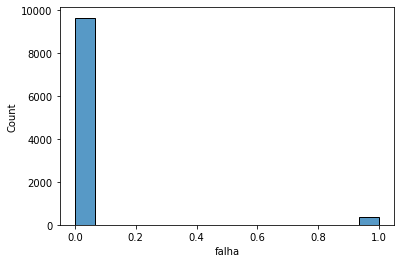

In [ ]:
ax = sns.histplot(data=dados, x='falha')

Plotei esse gráfico para entender um pouco mais sobre a correlação negativa entre torque e velocidade na rotação, confesso que fiquei um pouco curioso para saber como isso funcionava em gráficos, daí percebi que quando o torque menor que 10Nm é aplicado em um rpm no valor maior que 2500 a probabilidade de falha é grande, assim como, se a maquina o ultrapassa 65 nm o em um rpm menor que 1500/1250 a probabilidade da falha aumenta, ou seja, entender a correlação negativa que essas máquinas tem entre essas duas variaveis é essencial para a prevenção de falhas.

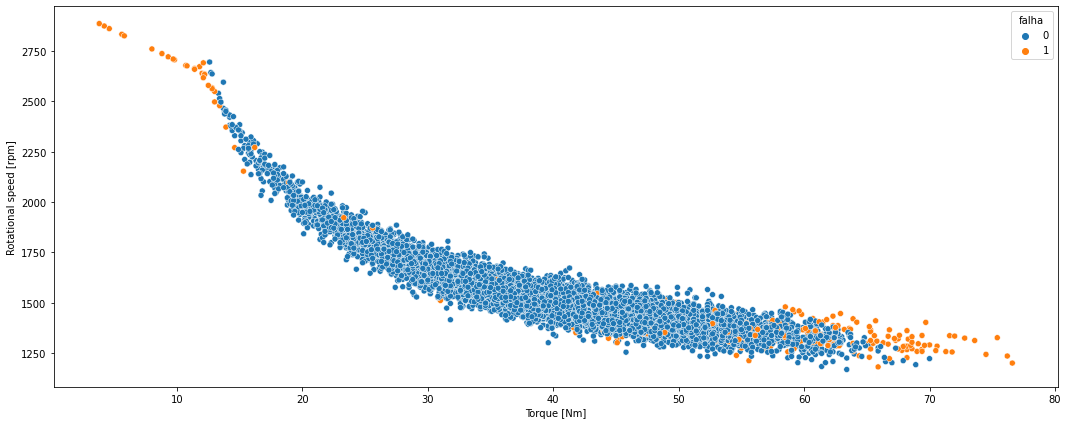

In [ ]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=dados, x="Torque [Nm]", y="Rotational speed [rpm]", hue="falha",palette="tab10");

# Importando algumas bibliotecas que me ajudará no AM


In [ ]:
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.metrics import accuracy_score

IMPORTANTE: Sempre separar as variáveis dependentes das independentes.

In [ ]:
X = dados.drop('falha', axis = 1)
y = dados.falha

Nestas linhas de código, separei os dados para treino e teste atraves da biblioteca do **sklearn -> train_test_split** - coloquei uma semente random pois a biblioteca train_test_split possui o RANDOM STATE = NONE, onde não controla o embaralhamento sem que você coloque algum valor - treinei o meu modelo com o LinearSVC, depois fiz um predict com os dados X de teste.

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 40
np.random.seed = SEED

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)


model = LinearSVC(random_state=SEED)
model.fit(X_train, y_train)

predict = model.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Medi a acurácia do meu modelo de previsão em relação aos meus dados y de teste e o resultado foi satisfatório, visto que eu queria uma taxa de erro de no máximo 5%. Posso depois usar e abusar de outros modelos, mas no momento, contente com esse! ✅

In [ ]:
acuracia = accuracy_score(y_test, predict)
acuracia * 100 

96.64

Por fim, brincando um pouco com o modelo, criei um for in onde você inputa os dados das máquinas semelhantes ao dataset e veja se ela precisa de reparos ou não, com uma taxa de 3% de erro.

In [ ]:
def prever():
  dados_entrada = []
  for i in range(6):  
    print(X_test.columns[i])  
    entrada = input()
    dados_entrada.append(entrada)

  df = pd.DataFrame(dados_entrada)
  df = df.T
  previsao = model.predict(df)
  if previsao == 0:
    print("A maquina não precisa de reparos")
  else:
    print("A maquina precisa de reparos")


In [ ]:
prever()

Air temperature [K]
15
Process temperature [K]
258
Rotational speed [rpm]
125
Torque [Nm]
58
Tool wear [min]
154
Target
1
A maquina não precisa de reparos


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
